In [1]:
import numpy as np
import cv2
import tensorflow as tf
import os
import sklearn as sk
import sklearn.model_selection
from imutils import paths
from skimage import io
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

tf.__version__

'2.1.0'

In [2]:
from tensorflow.python.keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [3]:
dataset = "C:/Users/User/Documents/python/pelagem_gatos/imagens"
dataset

'C:/Users/User/Documents/python/pelagem_gatos/imagens'

In [4]:
args={}
args["dataset"]=dataset
args

{'dataset': 'C:/Users/User/Documents/python/pelagem_gatos/imagens'}

In [5]:
iPaths = list(paths.list_images(args["dataset"]))  #image paths
data = []
labels = []
altura = 150
largura = 150
for iPath in iPaths:    
    label = iPath.split(os.path.sep)[-2]   #split the image paths
    image = io.imread(iPath)#cv2.imread(iPath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert images into RGB Channel
    image = cv2.resize(image, (altura, largura))  #Resizing the images
    #image = image[..., np.newaxis]
    if image.shape == (altura,largura,3):
        data.append(image)
        labels.append(label)


data = np.array(data) / 255.0
labels = np.array(labels)
labels

C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\PIL\TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 35520512 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19988480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\PIL\TiffImagePlugin.py:764: UserWarning: C

array(['bicolor', 'bicolor', 'bicolor', ..., 'tortoiseshell',
       'tortoiseshell', 'tortoiseshell'], dtype='<U14')

In [6]:
data

array([[[[0.30196078, 0.40392157, 0.39215686],
         [0.29803922, 0.43529412, 0.41568627],
         [0.31372549, 0.40392157, 0.36862745],
         ...,
         [0.21176471, 0.24705882, 0.02352941],
         [0.21960784, 0.25098039, 0.0745098 ],
         [0.24705882, 0.29803922, 0.2       ]],

        [[0.24705882, 0.35686275, 0.30196078],
         [0.28235294, 0.40784314, 0.35686275],
         [0.29411765, 0.39607843, 0.32156863],
         ...,
         [0.20392157, 0.2627451 , 0.05098039],
         [0.23921569, 0.28627451, 0.14117647],
         [0.25882353, 0.3254902 , 0.28627451]],

        [[0.19607843, 0.31372549, 0.21960784],
         [0.24313725, 0.36470588, 0.30196078],
         [0.25490196, 0.36470588, 0.26666667],
         ...,
         [0.21176471, 0.28235294, 0.06666667],
         [0.26666667, 0.31372549, 0.17647059],
         [0.23921569, 0.31764706, 0.2745098 ]],

        ...,

        [[0.02745098, 0.03137255, 0.01176471],
         [0.15686275, 0.19215686, 0.13333333]

In [7]:

LB = sk.preprocessing.LabelBinarizer()  #Initialize label binarizer
labelsCat = LB.fit_transform(labels)
labelsCat.shape
#labelsCat = to_categorical(labelsCat); print(labelsCat)

(5646, 9)

In [8]:
(X_train, X_test, Y_train, Y_test) = sk.model_selection.train_test_split(data, labelsCat,
    test_size=0.33, stratify=labels, random_state=42)
X_train

array([[[[0.76078431, 0.59607843, 0.44705882],
         [0.74901961, 0.57647059, 0.43921569],
         [0.74901961, 0.56862745, 0.42352941],
         ...,
         [0.74509804, 0.59215686, 0.47058824],
         [0.75294118, 0.59215686, 0.47058824],
         [0.76078431, 0.58823529, 0.4627451 ]],

        [[0.78823529, 0.61568627, 0.49411765],
         [0.76470588, 0.59607843, 0.45490196],
         [0.75294118, 0.59215686, 0.45490196],
         ...,
         [0.76470588, 0.61176471, 0.49019608],
         [0.75294118, 0.6       , 0.47058824],
         [0.76470588, 0.61568627, 0.45882353]],

        [[0.77254902, 0.60392157, 0.46666667],
         [0.75686275, 0.58431373, 0.44705882],
         [0.75294118, 0.57254902, 0.44313725],
         ...,
         [0.76862745, 0.60392157, 0.47843137],
         [0.76470588, 0.60784314, 0.47058824],
         [0.75294118, 0.60392157, 0.46666667]],

        ...,

        [[0.00784314, 0.00392157, 0.02352941],
         [0.01176471, 0.01176471, 0.01960784]

In [9]:
Y_train.shape

(3782, 9)

In [10]:

datagen = ImageDataGenerator(
   
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(X_train)
datagen

In [11]:
batch_size = 32
epochs = 100
 
num_classes = 9

In [12]:
balanced_gen = BalancedDataGenerator(X_train, Y_train, datagen, batch_size=batch_size)
steps_per_epoch = balanced_gen.steps_per_epoch
y_gen = [balanced_gen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True))

C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(array([0, 1]), array([92672, 11584], dtype=int64))


In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers  import Adam
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(altura,largura, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(), bias_initializer='zeros')(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(lr=0.0001)
# optimizer = RMSprop(lr=learning_rate)

loss = "categorical_crossentropy"
# loss = "kullback_leibler_divergence"

for layer in model.layers:
    layer.trainable = True
# for layer in model.layers[-2:]:
#     layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["AUC","accuracy"])

model.summary()
#for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

C:\Users\User\anaconda3\envs\gatos-gpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [14]:
with tf.device('/GPU:0'):
     R = model.fit(balanced_gen,steps_per_epoch=steps_per_epoch, epochs=epochs,validation_data=(X_test, Y_test), shuffle=True)
   # R = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),steps_per_epoch=len(X_train) / batch_size, epochs=epochs,validation_data=(X_test, Y_test))
   #R = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, Y_test), shuffle=True)    
R

  ...
    to  
  ['...']
Train for 362 steps, validate on 1864 samples
Epoch 1/100
362/362 [==============================] - 69s 190ms/step - loss: 0.4662 - AUC: 0.9847 - accuracy: 0.8476 - val_loss: 0.6986 - val_AUC: 0.9681 - val_accuracy: 0.8085
Epoch 2/100
362/362 [==============================] - 53s 145ms/step - loss: 0.1182 - AUC: 0.9984 - accuracy: 0.9629 - val_loss: 0.6932 - val_AUC: 0.9689 - val_accuracy: 0.8471
Epoch 3/100
362/362 [==============================] - 52s 145ms/step - loss: 0.0635 - AUC: 0.9993 - accuracy: 0.9826 - val_loss: 0.5827 - val_AUC: 0.9728 - val_accuracy: 0.8771
Epoch 4/100
362/362 [==============================] - 52s 144ms/step - loss: 0.0483 - AUC: 0.9995 - accuracy: 0.9847 - val_loss: 0.5518 - val_AUC: 0.9744 - val_accuracy: 0.8793
Epoch 5/100
362/362 [==============================] - 53s 145ms/step - loss: 0.0346 - AUC: 0.9996 - accuracy: 0.9904 - val_loss: 0.5416 - val_AUC: 0.9742 - val_accuracy: 0.8798
Epoch 6/100
362/362 [==================

Epoch 92/100
362/362 [==============================] - 52s 144ms/step - loss: 0.0013 - AUC: 1.0000 - accuracy: 0.9997 - val_loss: 0.8904 - val_AUC: 0.9651 - val_accuracy: 0.8975
Epoch 93/100
362/362 [==============================] - 53s 145ms/step - loss: 0.0055 - AUC: 1.0000 - accuracy: 0.9983 - val_loss: 0.9934 - val_AUC: 0.9623 - val_accuracy: 0.8906
Epoch 94/100
362/362 [==============================] - 52s 144ms/step - loss: 0.0119 - AUC: 0.9997 - accuracy: 0.9962 - val_loss: 1.2021 - val_AUC: 0.9559 - val_accuracy: 0.8750
Epoch 95/100
362/362 [==============================] - 53s 145ms/step - loss: 0.0085 - AUC: 0.9999 - accuracy: 0.9971 - val_loss: 1.2550 - val_AUC: 0.9514 - val_accuracy: 0.8702
Epoch 96/100
362/362 [==============================] - 52s 145ms/step - loss: 0.0111 - AUC: 0.9998 - accuracy: 0.9965 - val_loss: 1.2845 - val_AUC: 0.9532 - val_accuracy: 0.8788
Epoch 97/100
362/362 [==============================] - 52s 144ms/step - loss: 0.0072 - AUC: 0.9999 - acc

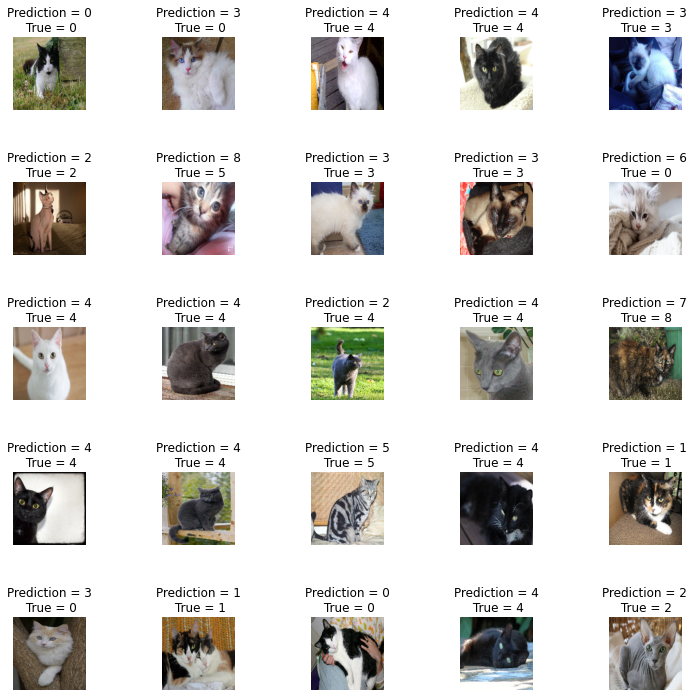

In [15]:
import matplotlib.pyplot as plt
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=batch_size)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1) 

In [16]:
from sklearn.metrics import classification_report
y_pred0 = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred0, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

                precision    recall  f1-score   support

       bicolor       0.83      0.79      0.81       147
        calico       0.91      0.84      0.87       161
      hairless       0.95      0.98      0.96       205
   point_color       0.90      0.92      0.91       240
   solid_color       0.95      0.97      0.96       636
 tabby_classic       0.81      0.81      0.81       108
tabby_mackerel       0.59      0.70      0.64       102
 tabby_spotted       0.87      0.76      0.81       206
 tortoiseshell       0.78      0.86      0.82        59

      accuracy                           0.89      1864
     macro avg       0.84      0.85      0.84      1864
  weighted avg       0.89      0.89      0.89      1864



In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.argmax(axis=1),y_pred)

0.8868025751072961

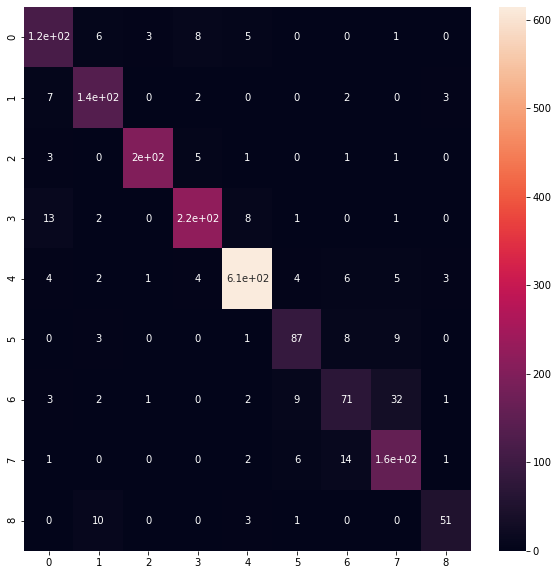

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_pred, Y_test.argmax(axis=1))
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

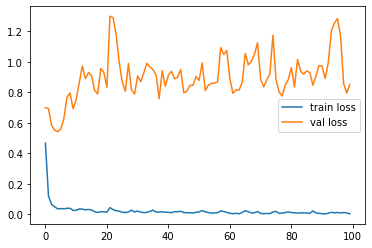

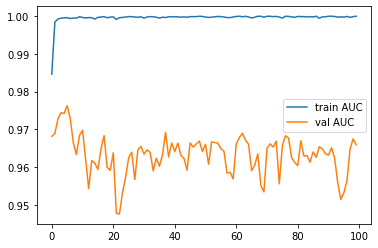

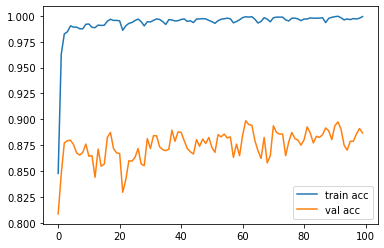

In [19]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

# plot the AUC
plt.plot(R.history['AUC'], label='train AUC')
plt.plot(R.history['val_AUC'], label='val AUC')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [20]:
model.save('model_mobileNET_8868.h5')
